In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import flax.linen as nn

from sklearn.datasets import make_moons
from rebayes_mini import callbacks
from functools import partial
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [12]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [13]:
palette = sns.color_palette()

In [20]:
n_samples = 500
X, y = make_moons(n_samples, noise=0.15, random_state=314)

angle = jnp.pi * -0.3
R = jnp.array([
    [jnp.cos(angle), -jnp.sin(angle)],
    [jnp.sin(angle), jnp.cos(angle)]
])
X = jnp.einsum("mn,sn->sm", R, X)

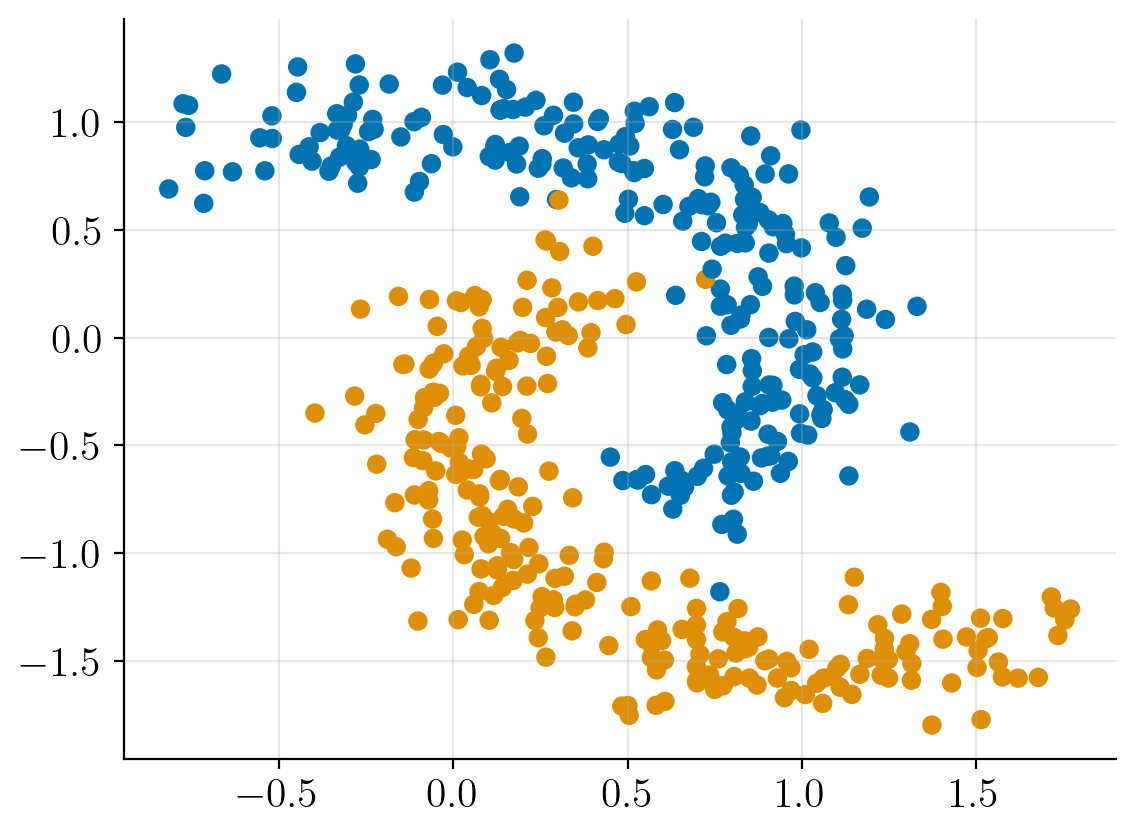

In [21]:
colors = [palette[v] for v in y]
plt.scatter(*X.T, c=colors)
plt.grid(alpha=0.3)

In [268]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        # x = nn.sigmoid(x)
        return x

In [269]:
key = jax.random.PRNGKey(314)
key_init, key_run = jax.random.split(key)

In [270]:
mlp = MLP()
params_init = mlp.init(key_init, X)

In [271]:
rvga_filter = rvga.BernoulliRVGA(mlp.apply, n_inner=2, n_samples=1_000)
bel_init = rvga_filter.init_bel(params_init)

In [304]:
bel_final, hist_bel = rvga_filter.scan(key_run, bel_init, y[:, None], X, callbacks.get_updated_bel)

In [305]:
preds = rvga_filter.mean(rvga_filter.link_fn(bel_final.mean, X).squeeze()).round()
(preds == y).mean()

Array(0.95800006, dtype=float32)

In [306]:
vmin, vmax = -2, 2.0
x1 = jnp.linspace(vmin, vmax, 20)
x2 = jnp.linspace(vmin, vmax, 25)
Z = jnp.mgrid[vmin:vmax:20j,vmin:vmax:25j]
# Z = jnp.einsum("nm,mij->nij", R, Z)

In [307]:
Z.shape

(2, 20, 25)

In [308]:
X.shape

(500, 2)

In [312]:
@partial(jax.vmap, in_axes=(None, 2))
@partial(jax.vmap, in_axes=(None, 1))
def vpred(params, X):
    return rvga_filter.mean(rvga_filter.link_fn(params, X).squeeze())

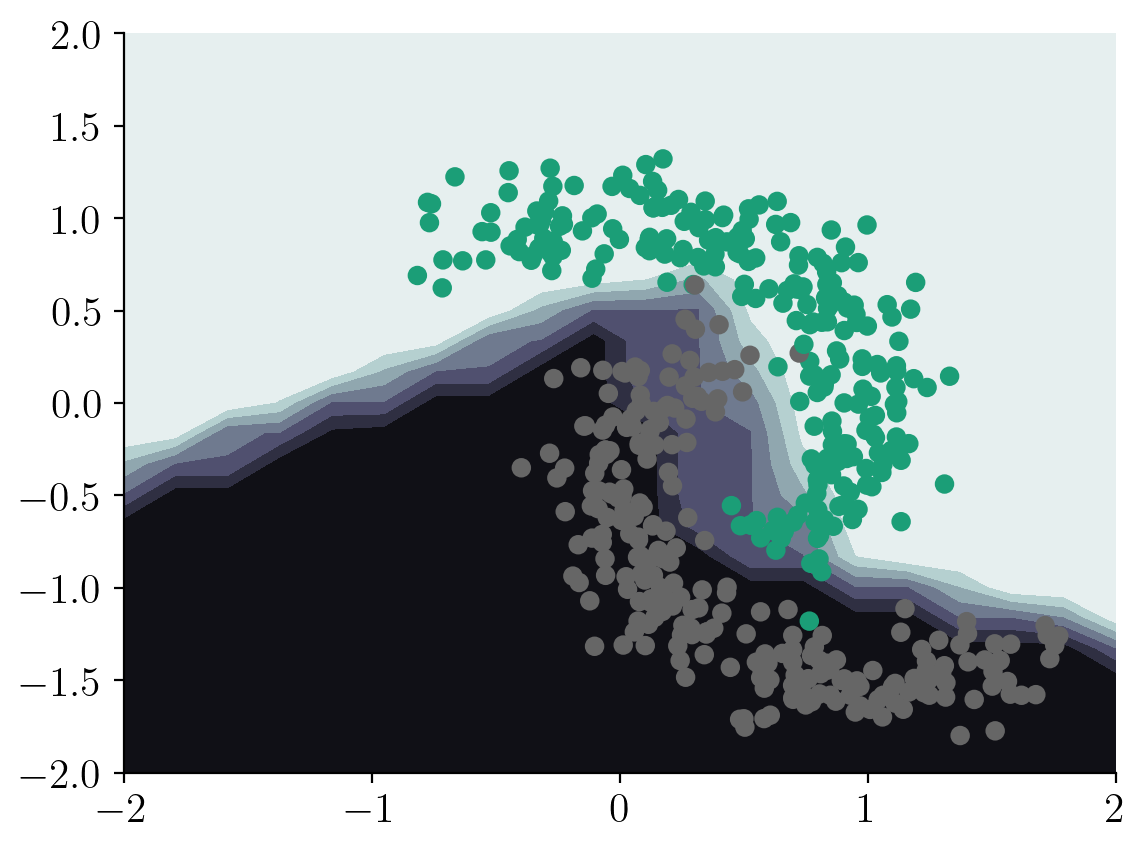

In [318]:
t = -1
S = vpred(hist_bel.mean[t], Z)
# S = vpred(bel_init.mean, Z)
plt.contourf(x1, x2, S, cmap="bone_r")
plt.scatter(*X[:t].T, c=y[:t], cmap="Dark2")

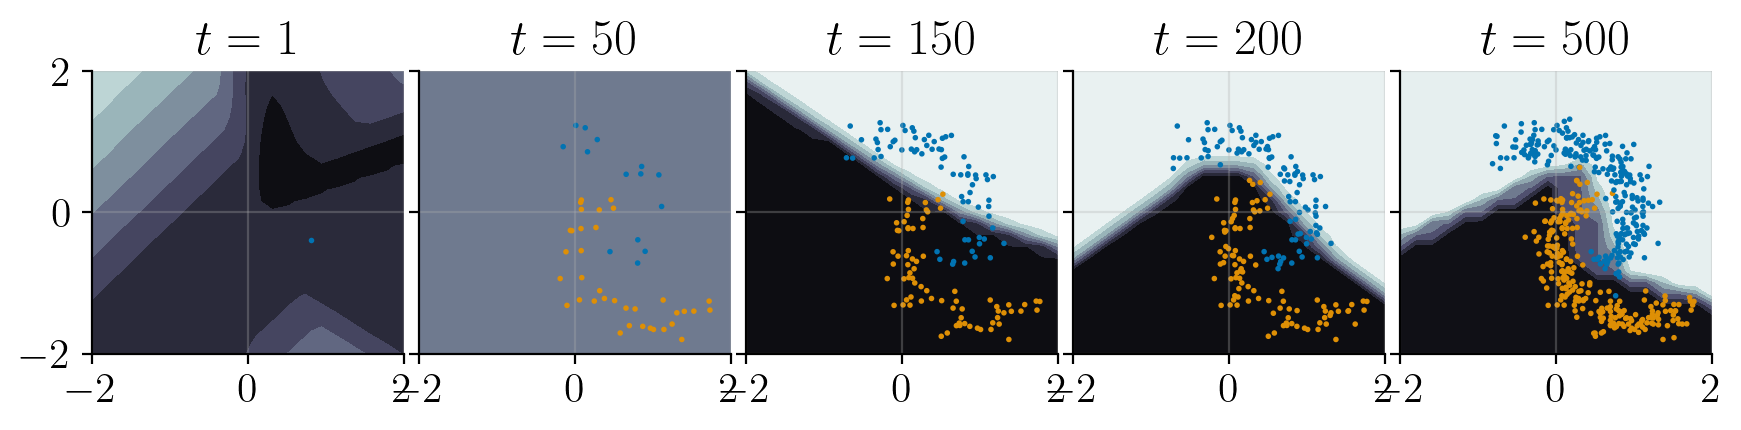

In [326]:
t = 2
# fig, axs = plt.subplots(1, 5, figsize=(10, 3), sharex=True, sharey=True)
fig, axs = plt.subplots(1, 5, figsize=(6.4 * 1.4, 4.8 * 0.5), sharey=True, sharex=True)
t_values = [1, 50, 150, 200, 500]

for axi, t in zip(axs.ravel(), t_values):
    plt.sca(axi)
    bel_mean = hist_bel.mean[t]

    S = vpred(bel_mean, Z)
    
    plt.contourf(x1, x2, S, cmap="bone_r")

    colors = [palette[v] for v in y[:t]]
    plt.scatter(*X[:t].T, c=colors, s=1)
    # plt.xlim(-v)
    # plt.ylim(-3, 5)
    plt.grid(alpha=0.3)
    plt.title(f"$t={t}$")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.0)
# plt.savefig("../figures/recursive-logreg.png", dpi=300, bbox_inches="tight")